In [1]:
import numpy as np
from brian2 import *
from brian2modelfitting import *

In [2]:
# set parameters
area = 1000*um**2
C_m = 1.*ufarad*cm**-2*area
E_l = -54.387*mV
E_K = -77.*mV
E_Na = 50.*mV
dt = 0.01*ms
init_conds = {'V': -65*mV, 'm': 0.05, 'h': 0.6, 'n': 0.32}
true_params = {'g_l': 0.3*mS*cm**-2*area,
               'g_Na': 120.*mS*cm**-2*area,
               'g_K': 36.*mS*cm**-2*area}
inp_trace = np.load('data/inp_trace.npy')
out_trace = np.load('data/out_trace_ground_truth.npy')

In [3]:
t = np.arange(0, inp_trace.size*dt/ms, dt/ms)

In [4]:
# set model definintion
eqs = '''
    # ode system
    dV/dt = ((I_inj
          - g_Na * m ** 3 * h * (V - E_Na)
          - g_K * n**4 * (V - E_K)
          - g_l * (V - E_l)) / C_m) : volt
    dm/dt = alpha_m * (1.0 - m) - beta_m * m : 1
    dh/dt = alpha_h * (1.0 - h) - beta_h * h : 1
    dn/dt = alpha_n * (1.0 - n) - beta_n * n : 1

    alpha_m = (0.1*mV**-1) * (V + 40.*mV) / (1. - exp(-(V + 40.*mV) / (10.*mV)))/ms : Hz
    beta_m = 4. * exp(-(V + 65.*mV) / (18.*mV))/ms : Hz
    alpha_h = 0.07 * exp(-(V + 65.*mV) / (20.*mV))/ms : Hz
    beta_h = 1. / (1. + exp(-(V + 35.*mV) / (10.*mV)))/ms : Hz
    alpha_n = (0.01*mV**-1) * (V + 55.*mV) / (1. - exp(-(V + 55.*mV) / (10.*mV)))/ms : Hz
    beta_n = 0.125 * exp(-(V + 65.*mV) / (80.*mV))/ms : Hz

    # parameters to fit
    g_Na : siemens (constant)
    g_K : siemens (constant)
    g_l : siemens (constant)
    '''

In [5]:
# Simulation-based inference object instantiation
inferencer = Inferencer(dt=dt, model=eqs,
                        input={'I_inj': inp_trace.reshape(1, -1)*uA*cm**-2*area},
                        output={'V': out_trace.reshape(1, -1)*mV},
                        param_init=init_conds,
                        method='exponential_euler')

In [6]:
posterior = inferencer.infere(n_samples=5_000,
                              inference_method='SNPE',
                              density_estimator_model='mdn',
                              g_l=[0.1*mS*cm**-2*area, 1.*mS*cm**-2*area],
                              g_Na=[60.*mS*cm**-2*area, 180.*mS*cm**-2*area],
                              g_K=[10.*mS*cm**-2*area, 50.*mS*cm**-2*area])

Round 1/1.
Neural network successfully converged after 62 epochs.


In [7]:
samples = inferencer.sample((10_000, ))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

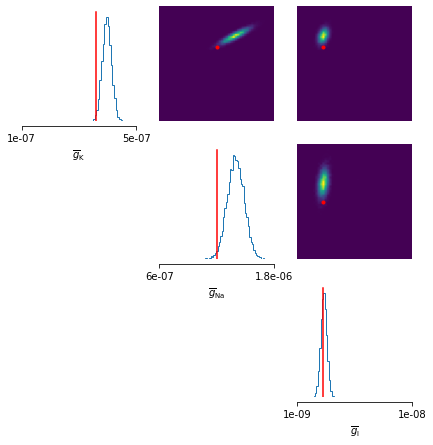

In [8]:
inferencer.pairplot(limits={'g_l': [0.1*mS*cm**-2*area, 1.*mS*cm**-2*area],
                            'g_Na': [60.*mS*cm**-2*area, 180.*mS*cm**-2*area],
                            'g_K': [10.*mS*cm**-2*area, 50.*mS*cm**-2*area]},
                    ticks={'g_l': [0.1*mS*cm**-2*area, 1.*mS*cm**-2*area],
                           'g_Na': [60.*mS*cm**-2*area, 180.*mS*cm**-2*area],
                           'g_K': [10.*mS*cm**-2*area, 50.*mS*cm**-2*area]},
                    labels={'g_l': r'$\overline{g}_\mathrm{l}$',
                            'g_Na': r'$\overline{g}_\mathrm{Na}$',
                            'g_K': r'$\overline{g}_\mathrm{K}$'},
                    points=true_params,
                    points_offdiag={'markersize': 6},
                    points_colors = ['r'],
                    figsize=(7, 7));

In [9]:
inf_trace = inferencer.generate_traces()

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

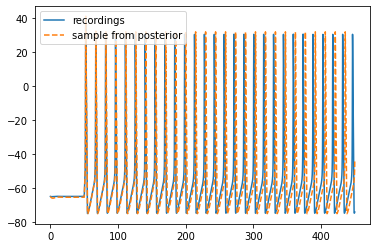

In [10]:
plt.plot(t, out_trace, label='recordings')
plt.plot(t, inf_trace.ravel()/mV, '--', label='sample from posterior')
plt.legend();